# Tracer Advection Initial Condition Definition

In order to define initial conditions on the cubed-sphere, we need to use some of the tools that have been described in `domain_decomposition_grid_generation.ipynb`. 
Specifically, we will need the `MetricTerms` portion of configuration in order to retrieve the coordinate information (latitude, longitude, dx, dy), the `QuantityFactory` for creating quantities and the `CubedSphereCommunicator` for gather data on tiles.

For tracer advection, initial conditions that need to be specified are for winds and pressure (which are held constant) and initial tracer concentration that will get advected.

In [1]:
# Number of tiles on the cube
ntiles = 6

# Size of each cubed-sphere tile
nx = 20
ny = 20
nz = 79

# Nubmer of halo-points
nhalo = 3

# Number of MPI-ranks along x- and y-direction on each tile
# Note: Must be equal for the time being
layout = (1, 1)
assert layout[0] == layout[1]

# GT4Py backend to use for storages
backend = "numpy"

# position of tracer centerpoint (lon, lat)
tracer_center = (0.0, 0.0)

# test case option
test_case = "b"
# - a: fortran test_case1; 
# - b: similar to a, but less dispersive

In [2]:
import ipyparallel as ipp

# spinup cluster of MPI-workers
num_ranks = ntiles * layout[0] * layout[1]
cluster = ipp.Cluster(engines="mpi", n=num_ranks).start_and_connect_sync()

# broadcast configuration to all workers
ar = cluster[:].push(
    {
        "ntiles": ntiles,
        "nx": nx,
        "ny": ny,
        "nz": nz,
        "nhalo": nhalo,
        "layout": layout,
        "backend": backend,
        "tracer_center": tracer_center,
        "test_case": test_case
    }
)

# start executing cells on the workers in parallel from here on
%autopx

Starting 6 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:05<00:00,  1.04engine/s]
%autopx enabled


In [3]:
from mpi4py import MPI

import functions as func
import importlib
importlib.reload(func)

mpi_comm = MPI.COMM_WORLD
mpi_rank = mpi_comm.Get_rank()

namelist_dict = func.store_namelist_variables(locals())
dimensions = func.define_dimensions(namelist_dict)

domain_configuration = func.configure_domain(mpi_comm, dimensions)
communicator = domain_configuration["communicator"]
metric_terms = domain_configuration["metric_terms"]
quantity_factory = domain_configuration["quantity_factory"]

%px:   0%|                                                                                                                                          | 0/6 [00:01<?, ?tasks/s]

[output:0]

%px:   0%|                                                                                                                                          | 0/6 [00:01<?, ?tasks/s]

[output:3]

[output:2]

%px:   0%|                                                                                                                                          | 0/6 [00:02<?, ?tasks/s]

[output:4]

%px:   0%|                                                                                                                                          | 0/6 [00:02<?, ?tasks/s]

[output:1]

%px:   0%|                                                                                                                                          | 0/6 [00:02<?, ?tasks/s]

[output:5]

%px:   0%|                                                                                                                                          | 0/6 [00:06<?, ?tasks/s]

[stderr:5] /usr/local/lib/python3.8/dist-packages/pace/util/grid/gnomonic.py:682: RuntimeWarning: invalid value encountered in true_divide
  np.sum(p * q, axis=-1)


[stderr:2] /usr/local/lib/python3.8/dist-packages/pace/util/grid/gnomonic.py:682: RuntimeWarning: invalid value encountered in true_divide
  np.sum(p * q, axis=-1)


%px: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.04s/tasks]


Read in all the required coordinate variables: longitude and latitude on cell edges (`lon`, `lat`) and cell centeres (`lonA`, `latA`) and distances between grid corners in x and y (`dx`, `dy`).
We take the definitions of all these quantites on the compute domain and halo points in order to ensure a smooth transition between tiles.

In [4]:
lon_agrid = metric_terms.lon_agrid
lat_agrid = metric_terms.lat_agrid

lon = metric_terms.lon
lat = metric_terms.lat

dx = metric_terms.dx
dy = metric_terms.dy

## Streamfunction Definition

The streamfunction is defined so that the winds along the equator make one full rotation around the globe in 12 days.
Note that `psi` is defined on cell corners and includes all the halo points, and `psi_agrid` is defined on cell centers.

In [5]:
import numpy as np
from pace.util.constants import RADIUS
from units_config import units

psi_agrid = quantity_factory.empty(
    dims=("x", "y", "z"), units=units["streamfunction"], dtype="float"
)
psi = quantity_factory.empty(
    dims=("x_interface", "y_interface", "z"), units=units["streamfunction"], dtype="float"
)

Ubar = (2.0 * np.pi * RADIUS) / (12.0 * 86400.0)

if test_case == "a":
    multiplier = np.sin(lat.data)
    multiplier_agrid = np.sin(lat_agrid.data)
elif test_case == "b":
    multiplier = np.sin(lat.data) * np.cos(lat.data / 2)
    multiplier_agrid = np.sin(lat_agrid.data) * np.cos(lat_agrid.data / 2)

psi_agrid.data[:, :, :-1] = -1 * Ubar * RADIUS * multiplier_agrid[:, :, np.newaxis]
psi.data[:, :, :-1] = -1 * Ubar * RADIUS * multiplier[:, :, np.newaxis]

## Calculating Winds from Streamfunction

The winds required by tracer advection are on a C-grid, so we calculate them from the streamfunction.

In [6]:
u_cgrid = quantity_factory.empty(
    dims=("x", "y_interface", "z"), units=units["wind"], dtype="float"
)
v_cgrid = quantity_factory.empty(
    dims=("x_interface", "y", "z"), units=units["wind"], dtype="float"
)

u_cgrid.data[:, :-1, :] = (
    -1 * (psi.data[:, 1:, :] - psi.data[:, :-1, :]) / dy.data[:, :-1, np.newaxis]
)
v_cgrid.data[:-1, :, :] = (psi.data[1:, :, :] - psi.data[:-1, :, :]) / dx.data[
    :-1, :, np.newaxis
]

## Defining pressure thickness

The thickness field is initialized with a constant thickness of `10 Pa`.

In [7]:
delp = quantity_factory.empty(
    dims=("x", "y", "z"), units=units["pressure"], dtype="float"
)
delp.data[:-1, :-1, :-1] = 10

## Defining the initial tracer state
We define the initial tracer state as a Gaussian blob centered on `tracer_center`. 
By default, the tracer is centered at the (0°N, 0°E), and has a maximum concentration of `1`.

In [8]:
from pace.util.grid.gnomonic import great_circle_distance_lon_lat

tracer = quantity_factory.zeros(
    dims=("x", "y", "z"), units=units["tracer"], dtype="float"
)


r0 = RADIUS / 3.0
p_center = [np.deg2rad(tracer_center[0]), np.deg2rad(tracer_center[1])]

for jj in range(tracer.data.shape[1] - 1):
    for ii in range(tracer.data.shape[0] - 1):

        p_dist = [lon.data[ii, jj], lat.data[ii, jj]]
        r = great_circle_distance_lon_lat(
            p_center[0], p_dist[0], p_center[1], p_dist[1], RADIUS, np
        )

        tracer.data[ii, jj, :-1] = (
            0.5 * (1.0 + np.cos(np.pi * r / r0)) if r < r0 else 0.0
        )

## Plotting the initial condition

[stderr:0] [4d6ab76db141:01953] Read -1, expected 32768, errno = 1
[4d6ab76db141:01953] Read -1, expected 220032, errno = 1
[4d6ab76db141:01953] Read -1, expected 32768, errno = 1
[4d6ab76db141:01953] Read -1, expected 220032, errno = 1
[4d6ab76db141:01953] Read -1, expected 32768, errno = 1
[4d6ab76db141:01953] Read -1, expected 220032, errno = 1
[4d6ab76db141:01953] Read -1, expected 32768, errno = 1
[4d6ab76db141:01953] Read -1, expected 220032, errno = 1
[4d6ab76db141:01953] Read -1, expected 32768, errno = 1
[4d6ab76db141:01953] Read -1, expected 220032, errno = 1
[4d6ab76db141:01953] Read -1, expected 32768, errno = 1
[4d6ab76db141:01953] Read -1, expected 220032, errno = 1
[4d6ab76db141:01953] Read -1, expected 32768, errno = 1
[4d6ab76db141:01953] Read -1, expected 220032, errno = 1
[4d6ab76db141:01953] Read -1, expected 32768, errno = 1
[4d6ab76db141:01953] Read -1, expected 220032, errno = 1
[4d6ab76db141:01953] Read -1, expected 32768, errno = 1
[4d6ab76db141:01953] Read -1,

[output:0]

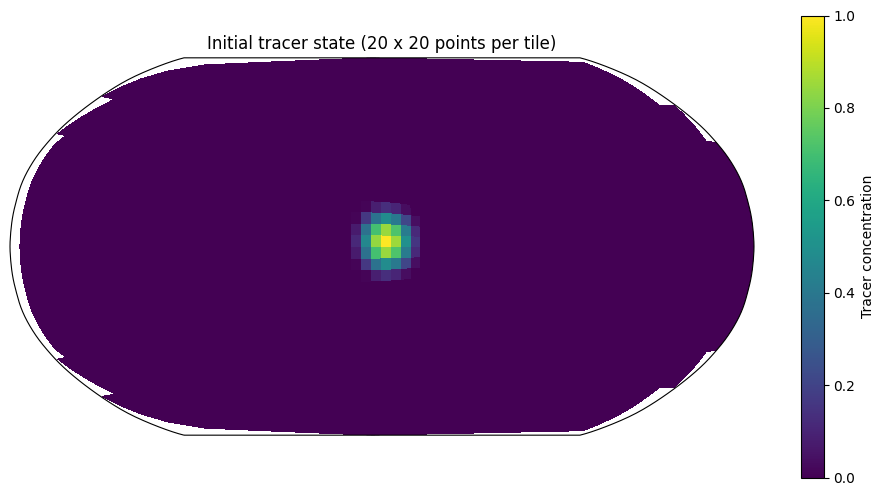

[output:0]

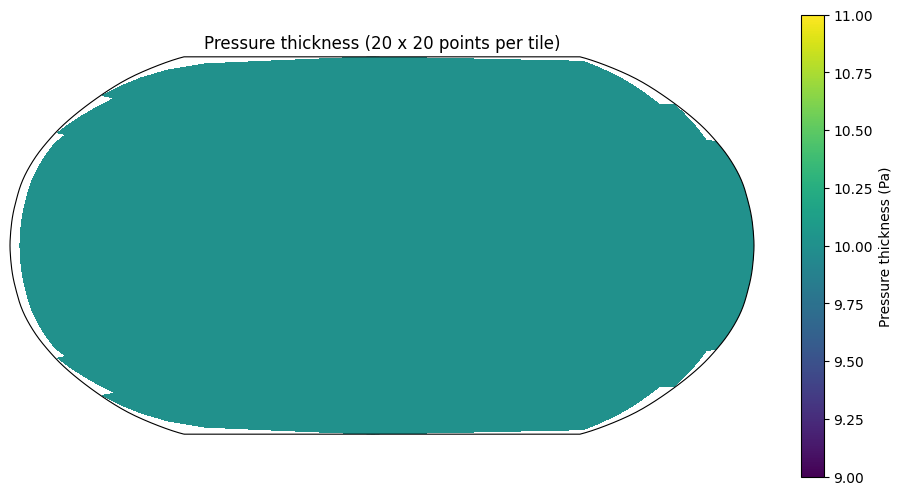

[output:0]

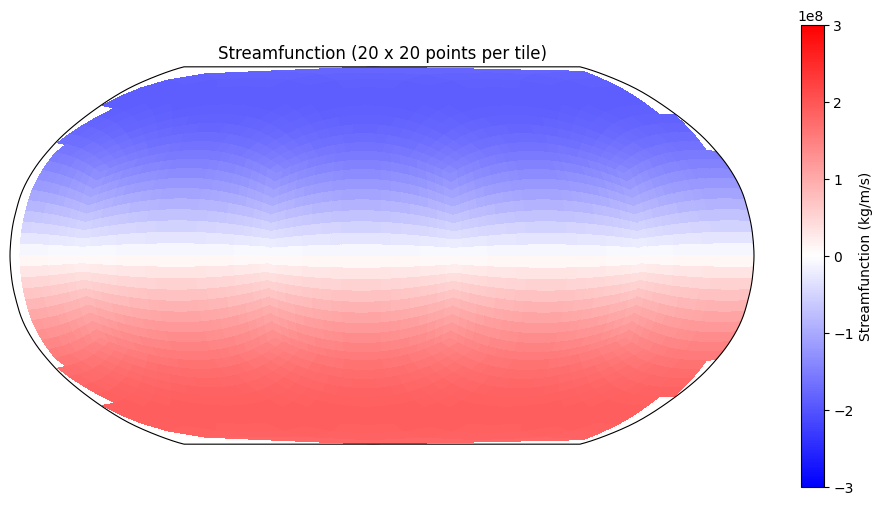

In [9]:
import matplotlib.pyplot as plt
from cartopy import crs as ccrs
from fv3viz import pcolormesh_cube

lon_plot = quantity_factory.zeros(
    dims=("x_interface", "y_interface"), units=units["coord-deg"], dtype="float"
)
lon_plot.data[:] = metric_terms.lon.data * 180 / np.pi

lat_plot = quantity_factory.zeros(
    dims=("x_interface", "y_interface"), units=units["coord-deg"], dtype="float"
)
lat_plot.data[:] = metric_terms.lat.data * 180 / np.pi

lon_gather = communicator.gather(lon_plot)
lat_gather = communicator.gather(lat_plot)

psi_gather = communicator.gather(psi_agrid)
delp_gather = communicator.gather(delp)
tracer_gather = communicator.gather(tracer)

if mpi_rank == 0:

    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111, projection=ccrs.Robinson())
    f1 = pcolormesh_cube(
        lat_gather.data,
        lon_gather.data,
        tracer_gather.data[:, :, :, 0],
        vmin=0,
        vmax=1,
        cmap="viridis",
    )
    plt.colorbar(f1, label="Tracer concentration")
    ax.set_title("Initial tracer state (%s x %s points per tile)" % (nx, ny))

    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111, projection=ccrs.Robinson())
    f1 = pcolormesh_cube(
        lat_gather.data,
        lon_gather.data,
        delp_gather.data[:, :, :, 0],
        vmin=9,
        vmax=11,
        cmap="viridis",
    )
    plt.colorbar(f1, label="Pressure thickness (Pa)")
    ax.set_title("Pressure thickness (%s x %s points per tile)" % (nx, ny))

    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111, projection=ccrs.Robinson())
    f1 = pcolormesh_cube(
        lat_gather.data,
        lon_gather.data,
        psi_gather.data[:, :, :, 0],
        vmin=-3e8,
        vmax=3e8,
        cmap="bwr",
    )
    plt.colorbar(f1, label="Streamfunction (kg/m/s)")
    ax.set_title("Streamfunction (%s x %s points per tile)" % (nx, ny))

    plt.show()

Since `u_cgrid` and `v_cgrid` are staggered fields, we need to unstagger them before plotting.
For simplicity, this is here done by removing the last point on the staggered dimension.

Also note that the u and v winds on the C-grid look strange because different tiles are oriented differently.

[stderr:0] [4d6ab76db141:01953] Read -1, expected 32768, errno = 1
[4d6ab76db141:01953] Read -1, expected 232672, errno = 1
[4d6ab76db141:01953] Read -1, expected 32768, errno = 1
[4d6ab76db141:01953] Read -1, expected 232672, errno = 1
[4d6ab76db141:01953] Read -1, expected 32768, errno = 1
[4d6ab76db141:01953] Read -1, expected 232672, errno = 1
[4d6ab76db141:01953] Read -1, expected 32768, errno = 1
[4d6ab76db141:01953] Read -1, expected 232672, errno = 1
[4d6ab76db141:01953] Read -1, expected 32768, errno = 1
[4d6ab76db141:01953] Read -1, expected 232672, errno = 1
[4d6ab76db141:01953] Read -1, expected 32768, errno = 1
[4d6ab76db141:01953] Read -1, expected 232672, errno = 1
[4d6ab76db141:01953] Read -1, expected 32768, errno = 1
[4d6ab76db141:01953] Read -1, expected 232672, errno = 1
[4d6ab76db141:01953] Read -1, expected 32768, errno = 1
[4d6ab76db141:01953] Read -1, expected 232672, errno = 1
[4d6ab76db141:01953] Read -1, expected 32768, errno = 1
[4d6ab76db141:01953] Read -1,

[output:0]

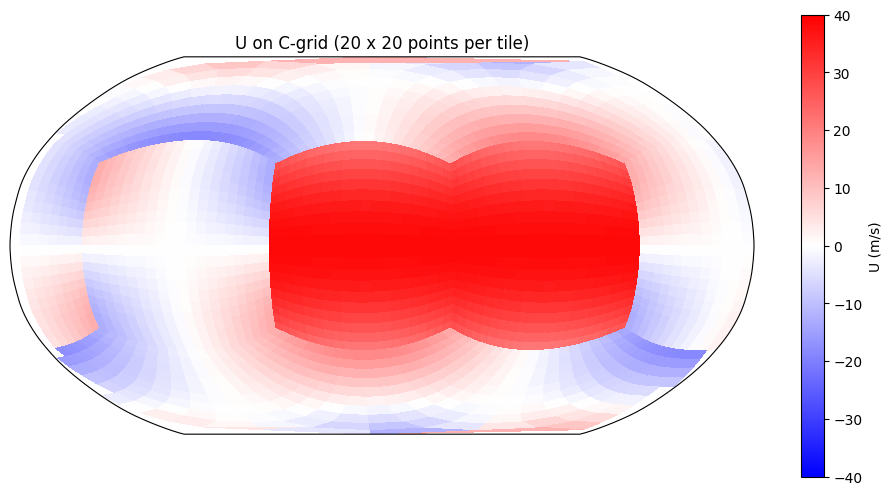

[output:0]

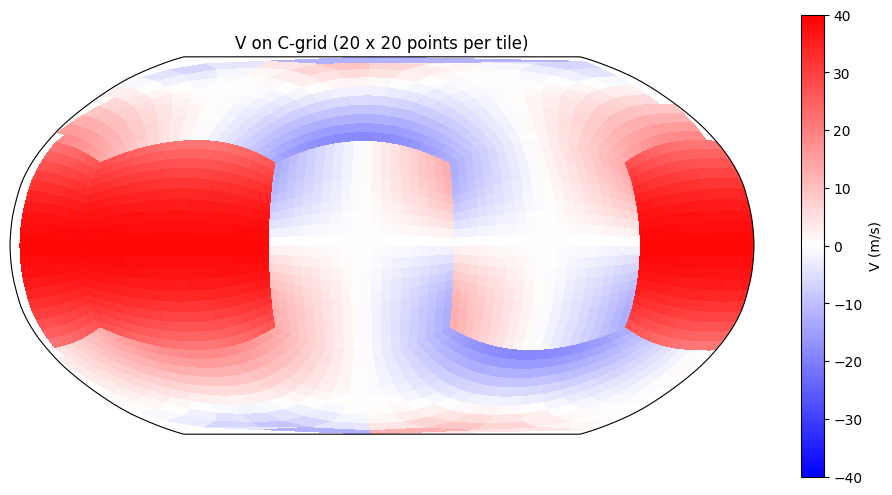

In [10]:
u_cgrid_gather = communicator.gather(u_cgrid)
v_cgrid_gather = communicator.gather(v_cgrid)

if mpi_rank == 0:

    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111, projection=ccrs.Robinson())
    f1 = pcolormesh_cube(
        lat_gather.data,
        lon_gather.data,
        u_cgrid_gather.data[:, :, :-1, 0],
        vmin=-40,
        vmax=40,
        cmap="bwr",
    )
    plt.colorbar(f1, label="U (m/s)")
    ax.set_title("U on C-grid (%s x %s points per tile)" % (nx, ny))

    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111, projection=ccrs.Robinson())
    f1 = pcolormesh_cube(
        lat_gather.data,
        lon_gather.data,
        v_cgrid_gather.data[:, :-1, :, 0],
        vmin=-40,
        vmax=40,
        cmap="bwr",
    )
    plt.colorbar(f1, label="V (m/s)")
    ax.set_title("V on C-grid (%s x %s points per tile)" % (nx, ny))

    plt.show()

## Recreating this with functions.py

You can reproduce the above steps in a more succinct manner by using the following syntax:

In [11]:
import functions as func
from mpi4py import MPI

mpi_comm = MPI.COMM_WORLD
mpi_rank = mpi_comm.Get_rank()

namelist_dict = func.store_namelist_variables(locals())
dimensions = func.define_dimensions(namelist_dict)

domain_configuration = func.configure_domain(mpi_comm, dimensions, single_layer=True)
communicator = domain_configuration["communicator"]
metric_terms = domain_configuration["metric_terms"]


initial_state = func.create_initial_state_advection(
    metric_terms, dimensions, tracer_center, test_case
)

[stderr:5] /usr/local/lib/python3.8/dist-packages/pace/util/grid/gnomonic.py:682: RuntimeWarning: invalid value encountered in true_divide
  np.sum(p * q, axis=-1)


[stderr:2] /usr/local/lib/python3.8/dist-packages/pace/util/grid/gnomonic.py:682: RuntimeWarning: invalid value encountered in true_divide
  np.sum(p * q, axis=-1)


[stderr:0] [4d6ab76db141:01953] Read -1, expected 32768, errno = 1
[4d6ab76db141:01953] Read -1, expected 220032, errno = 1
[4d6ab76db141:01953] Read -1, expected 32768, errno = 1
[4d6ab76db141:01953] Read -1, expected 220032, errno = 1
[4d6ab76db141:01953] Read -1, expected 32768, errno = 1
[4d6ab76db141:01953] Read -1, expected 220032, errno = 1
[4d6ab76db141:01953] Read -1, expected 32768, errno = 1
[4d6ab76db141:01953] Read -1, expected 220032, errno = 1
[4d6ab76db141:01953] Read -1, expected 32768, errno = 1
[4d6ab76db141:01953] Read -1, expected 220032, errno = 1
[4d6ab76db141:01953] Read -1, expected 32768, errno = 1
[4d6ab76db141:01953] Read -1, expected 220032, errno = 1
[4d6ab76db141:01953] Read -1, expected 32768, errno = 1
[4d6ab76db141:01953] Read -1, expected 220032, errno = 1
[4d6ab76db141:01953] Read -1, expected 32768, errno = 1
[4d6ab76db141:01953] Read -1, expected 220032, errno = 1
[4d6ab76db141:01953] Read -1, expected 32768, errno = 1
[4d6ab76db141:01953] Read -1,

[output:0]

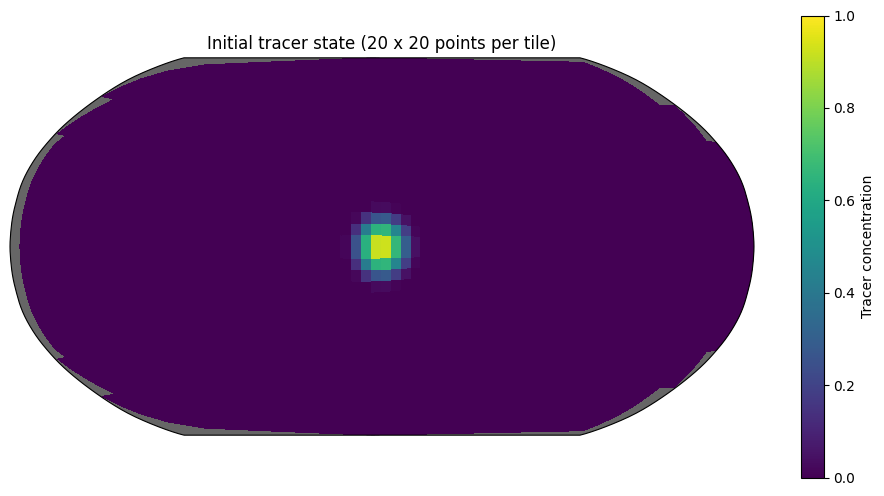

[output:0]

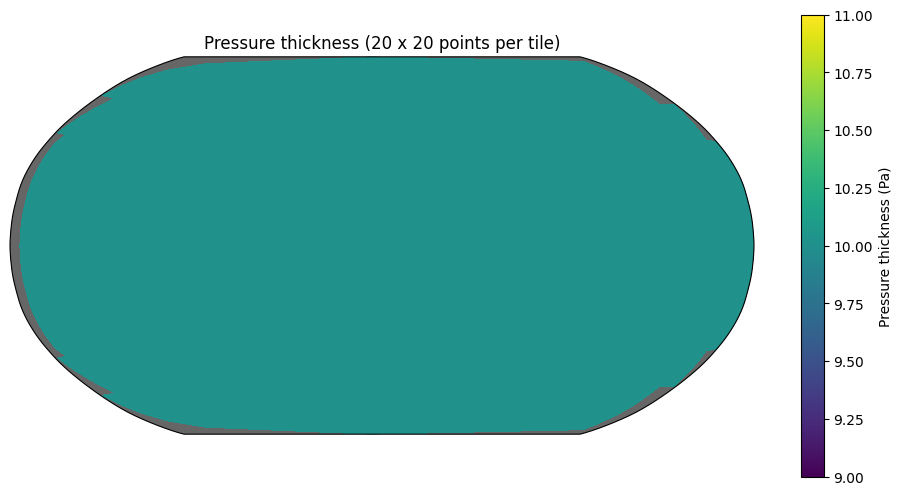

[output:0]

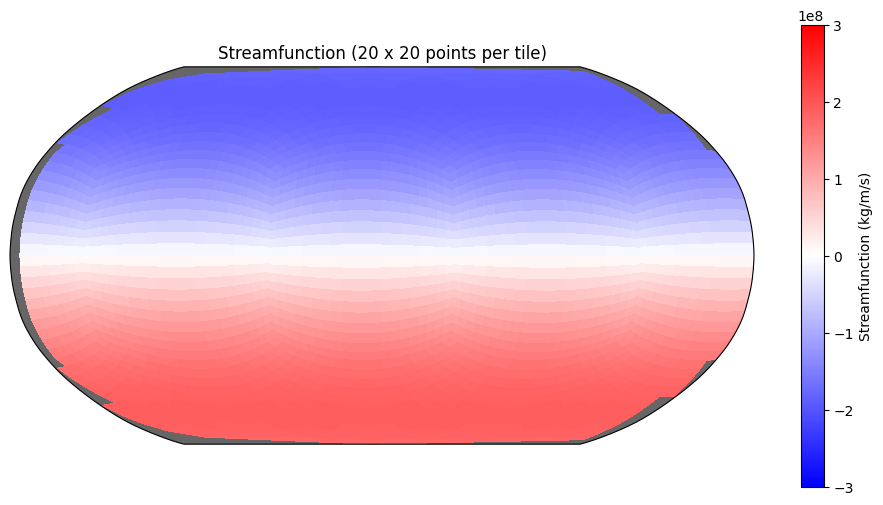

In [12]:
streamfunction_gather = communicator.gather(initial_state["psi"])
delp_gather = communicator.gather(initial_state["delp"])
tracer_gather = communicator.gather(initial_state["tracer"])

if mpi_rank == 0:
    plot_dict = {
        "vmin": 0,
        "vmax": 1,
        "cmap": "viridis",
        "units": "Tracer concentration",
        "title": "Initial tracer state (%s x %s points per tile)" % (nx, ny),
    }

    func.plot_projection_field(
        lon_gather, lat_gather, tracer_gather, plot_dict, "", show=True
    )

    plot_dict = {
        "vmin": 9,
        "vmax": 11,
        "cmap": "viridis",
        "units": "Pressure thickness (Pa)",
        "title": "Pressure thickness (%s x %s points per tile)" % (nx, ny),
    }
    func.plot_projection_field(
        lon_gather, lat_gather, delp_gather, plot_dict, "", show=True
    )

    plot_dict = {
        "vmin": -3e8,
        "vmax": 3e8,
        "cmap": "bwr",
        "units": "Streamfunction (kg/m/s)",
        "title": "Streamfunction (%s x %s points per tile)" % (nx, ny),
    }
    func.plot_projection_field(
        lon_gather, lat_gather, streamfunction_gather, plot_dict, "", show=True
    )

[stderr:0] [4d6ab76db141:01953] Read -1, expected 32768, errno = 1
[4d6ab76db141:01953] Read -1, expected 232672, errno = 1
[4d6ab76db141:01953] Read -1, expected 32768, errno = 1
[4d6ab76db141:01953] Read -1, expected 232672, errno = 1
[4d6ab76db141:01953] Read -1, expected 32768, errno = 1
[4d6ab76db141:01953] Read -1, expected 232672, errno = 1
[4d6ab76db141:01953] Read -1, expected 32768, errno = 1
[4d6ab76db141:01953] Read -1, expected 232672, errno = 1
[4d6ab76db141:01953] Read -1, expected 32768, errno = 1
[4d6ab76db141:01953] Read -1, expected 232672, errno = 1
[4d6ab76db141:01953] Read -1, expected 32768, errno = 1
[4d6ab76db141:01953] Read -1, expected 232672, errno = 1
[4d6ab76db141:01953] Read -1, expected 32768, errno = 1
[4d6ab76db141:01953] Read -1, expected 232672, errno = 1
[4d6ab76db141:01953] Read -1, expected 32768, errno = 1
[4d6ab76db141:01953] Read -1, expected 232672, errno = 1
[4d6ab76db141:01953] Read -1, expected 32768, errno = 1
[4d6ab76db141:01953] Read -1,

[output:0]

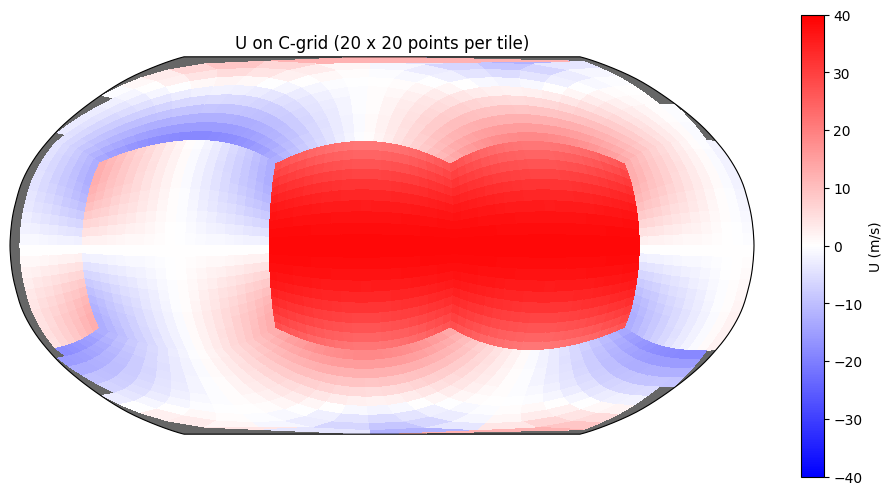

[output:0]

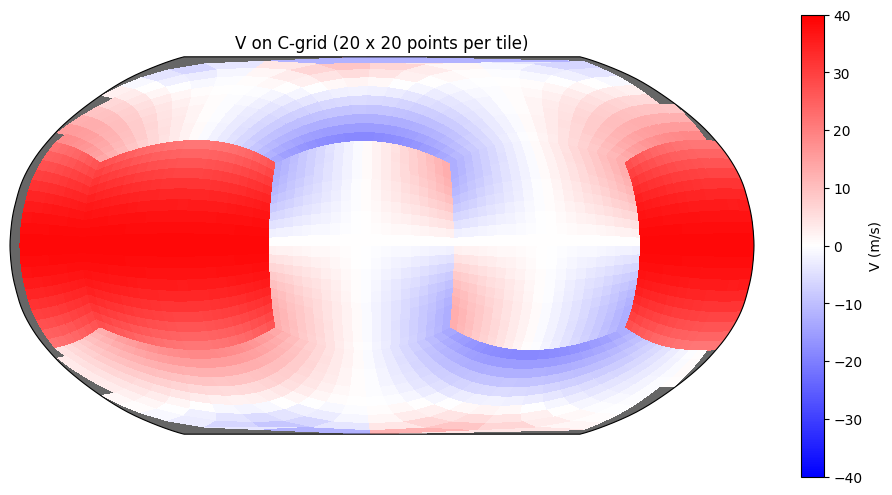

In [13]:
u_cgrid_gather = communicator.gather(initial_state["u_cgrid"])
v_cgrid_gather = communicator.gather(initial_state["v_cgrid"])

if mpi_rank == 0:
    plot_dict = {
        "vmin": -40,
        "vmax": 40,
        "cmap": "bwr",
        "units": "U (m/s)",
        "title": "U on C-grid (%s x %s points per tile)" % (nx, ny),
    }
    func.plot_projection_field(
        lon_gather, lat_gather, u_cgrid_gather, plot_dict, "", show=True
    )

    plot_dict = {
        "vmin": -40,
        "vmax": 40,
        "cmap": "bwr",
        "units": "V (m/s)",
        "title": "V on C-grid (%s x %s points per tile)" % (nx, ny),
    }
    func.plot_projection_field(
        lon_gather, lat_gather, v_cgrid_gather, plot_dict, "", show=True
    )